In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
from sklearn.metrics import adjusted_rand_score, auc
from scipy.stats import rankdata
import itertools

In [4]:
from pygraphs.cluster import KKMeans_vanilla as KKMeans, KWard, KMeans_sklearn, Ward_sklearn
from pygraphs.graphs.generator import StochasticBlockModel, RubanovModel
from pygraphs.measure import kernels, distances, scaler
from pygraphs.measure.kernel import Kernel
from pygraphs.scenario import ParallelByGraphs, RejectCurve, d3_colors, plot_results
from pygraphs.scorer import rand_index, triplet_measure, ranking

In [28]:
optimal_params_KKMeans = {  # for (100, 2, 0.3, 0.1)
    'pWalk': 0.61,
    'Walk': 0.37,
    'For': 0.86,
    'logFor': 0.12,
    'Comm': 0.31,
    'logComm': 0.53,
    'Heat': 0.77,
    'logHeat': 0.12,
    'NHeat': 0.93,
    'logNHeat': 0.93,
    'SCT': 0.94,
    'SCCT': 0.90,
    'RSP': 0.71,
    'FE': 0.47,
    'PPR': 0.96,
    'logPPR': 0.16,
    'ModifPPR': 0.86,
    'logModifPPR': 0.57,
    'HeatPPR': 0.98,
    'logHeatPPR': 0.96,
    'SP-CT': 0.85
}
optimal_params_KWard = {
    'pWalk': 0.87,
    'Walk': 0.74,
    'For': 1.00,
    'logFor': 0.54,
    'Comm': 0.31,
    'logComm': 0.56,
    'Heat': 0.84,
    'logHeat': 0.44,
    'NHeat': 0.94,
    'logNHeat': 0.97,
    'SCT': 0.48,
    'SCCT': 1.00,
    'RSP': 0.98,
    'FE': 0.93,
    'PPR': 0.99,
    'logPPR': 0.93,
    'ModifPPR': 0.99,
    'logModifPPR': 0.93,
    'HeatPPR': 0.96,
    'logHeatPPR': 0.96,
    'SP-CT': 0.03
}

In [6]:
graphs, _ = StochasticBlockModel(100, 2, p_in=0.3, p_out=0.1).generate_graphs(100)
y_true = [y_true_sample for A, y_true_sample in graphs]

# Triplet measure vs in-out AUC vs k-means ARI

Эксперимент с ранговыми корреляциями триплетного скора (берем все тройки, где 2 из 3 семплов относятся к одному классу, проверяем условие d(s1, s2) < d(s1, s3), мера – доля правильных ответов) vs in-out AUC vs k-means ARI.

## For optimal params for KKMeans

Сначала насчитаем все кернелы по заранее определенным оптимальным параметрам

In [14]:
K = defaultdict(list)
D = defaultdict(list)
for kernel, distance in tqdm(zip(kernels, distances), total=len(kernels)):
    for A, _ in graphs:
        param_flat = optimal_params_KKMeans[kernel.name]
        param = kernel(A).scaler.scale(param_flat)
        K[kernel.name].append(kernel(A).get_K(param))
        D[kernel.name].append(distance(A).get_D(param))

Теперь насчитаем k-means ARI

In [15]:
KKMeans_ARI = defaultdict(list)
for kernel_name, K_k in tqdm(K.items()):
    for idx, K_k_g in enumerate(K_k):
        y_pred = KKMeans(2).fit_predict(K_k_g)
        ari = adjusted_rand_score(y_true[idx], y_pred)
        KKMeans_ARI[kernel_name].append(ari)

KKMeans_ARI_mean = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in KKMeans_ARI.items()])
sorted(KKMeans_ARI_mean.items(), key=lambda x: -x[1])

[('SCT', 0.9694395880677048),
 ('NHeat', 0.9655201433099758),
 ('HeatPPR', 0.9639118207969888),
 ('SCCT', 0.9628166949080018),
 ('logComm', 0.9603520398151864),
 ('logNHeat', 0.9550520838622191),
 ('logPPR', 0.9376250473571219),
 ('RSP', 0.9318220181386194),
 ('Comm', 0.9186198100987175),
 ('logHeatPPR', 0.9078244612366304),
 ('FE', 0.9016842938381344),
 ('Walk', 0.8907144113356793),
 ('logModifPPR', 0.8837285996910086),
 ('logHeat', 0.8778679716070055),
 ('logFor', 0.872318160236928),
 ('SP-CT', 0.7936798201108938),
 ('Heat', 0.7857272105633796),
 ('pWalk', 0.24669909420526584),
 ('PPR', 0.2385993713027312),
 ('For', 0.04226423492569007),
 ('ModifPPR', 0.015326702128008381)]

In [16]:
KWard_ARI = defaultdict(list)
for kernel_name, K_k in tqdm(K.items()):
    for idx, K_k_g in enumerate(K_k):
        y_pred = KWard(2).fit_predict(K_k_g)
        ari = adjusted_rand_score(y_true[idx], y_pred)
        KWard_ARI[kernel_name].append(ari)

KWard_ARI_mean = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in KWard_ARI.items()])
sorted(KWard_ARI_mean.items(), key=lambda x: -x[1])

[('HeatPPR', 0.9480448771868802),
 ('logComm', 0.9456662265600799),
 ('NHeat', 0.9209068581821392),
 ('logNHeat', 0.9167494066412067),
 ('SCCT', 0.9122563705860252),
 ('Comm', 0.8774308428380035),
 ('PPR', 0.8468688675546212),
 ('logHeat', 0.8161837847609688),
 ('logFor', 0.8102294061093775),
 ('SCT', 0.8088796030045957),
 ('Walk', 0.8036565415067832),
 ('logModifPPR', 0.780453753745223),
 ('pWalk', 0.7789743154602539),
 ('Heat', 0.7558031060859155),
 ('logHeatPPR', 0.7527653461981768),
 ('FE', 0.7112393545345499),
 ('logPPR', 0.6584413027438387),
 ('SP-CT', 0.6124640795660004),
 ('For', 0.41820334007862797),
 ('RSP', 0.12607991532027232),
 ('ModifPPR', 0.11372389588228905)]

In [17]:
KMeans_sklearn_ARI = defaultdict(list)
for kernel_name, K_k in tqdm(K.items()):
    for idx, K_k_g in enumerate(K_k):
        y_pred = KMeans_sklearn(2).fit_predict(K_k_g)
        ari = adjusted_rand_score(y_true[idx], y_pred)
        KMeans_sklearn_ARI[kernel_name].append(ari)

KMeans_sklearn_ARI_mean = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in KMeans_sklearn_ARI.items()])
sorted(KMeans_sklearn_ARI_mean.items(), key=lambda x: -x[1])

[('logModifPPR', 0.967447517814779),
 ('logHeat', 0.9663363103951488),
 ('logPPR', 0.9662555044920677),
 ('FE', 0.9655281254912509),
 ('logFor', 0.9655200813632037),
 ('RSP', 0.9654634852283313),
 ('logHeatPPR', 0.965103834911671),
 ('Walk', 0.9647765014315719),
 ('SCCT', 0.9635682776078848),
 ('SCT', 0.9627521977323552),
 ('SP-CT', 0.9627117302970335),
 ('HeatPPR', 0.9619924732012306),
 ('PPR', 0.9557537438427259),
 ('Heat', 0.7718627422338361),
 ('pWalk', 0.6965831363342933),
 ('For', 0.5585713447301959),
 ('ModifPPR', 0.22418149135249776),
 ('Comm', 0.09654887731136823),
 ('logComm', 0.03150220260594263),
 ('logNHeat', 0.015773632195050107),
 ('NHeat', 0.014863385356078682)]

In [18]:
Ward_sklearn_ARI = defaultdict(list)
for kernel_name, K_k in tqdm(K.items()):
    for idx, K_k_g in enumerate(K_k):
        y_pred = Ward_sklearn(2).fit_predict(K_k_g)
        ari = adjusted_rand_score(y_true[idx], y_pred)
        Ward_sklearn_ARI[kernel_name].append(ari)

Ward_sklearn_ARI_mean = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in Ward_sklearn_ARI.items()])
sorted(Ward_sklearn_ARI_mean.items(), key=lambda x: -x[1])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

[('SCCT', 0.950828945058349),
 ('HeatPPR', 0.9496126829615938),
 ('logHeat', 0.9332228087288439),
 ('logHeatPPR', 0.928241015405237),
 ('RSP', 0.9224517041161151),
 ('SCT', 0.9220400997422422),
 ('logModifPPR', 0.9203903228632023),
 ('Walk', 0.9180475524122896),
 ('logFor', 0.915254048639992),
 ('FE', 0.9151860004361384),
 ('logPPR', 0.9128429397753008),
 ('PPR', 0.874882243643921),
 ('SP-CT', 0.8372121651922949),
 ('pWalk', 0.8170957641782367),
 ('Heat', 0.7654936696462268),
 ('For', 0.56333750853333),
 ('ModifPPR', 0.270790977532042),
 ('Comm', 0.1795312917433716),
 ('NHeat', 0.04404732952391622),
 ('logComm', 0.030844513310348973),
 ('logNHeat', 0.025387606959008022)]

Хорошо, теперь давайте посмотрим на in-out

In [19]:
rq = defaultdict(list)
for kernel_name, D_m in tqdm(D.items()):
    for idx, D_m_g in enumerate(D_m):
        tpr, fpr = RejectCurve._reject_curve(D_m_g, y_true[idx], need_shuffle=True)
        rq[kernel_name].append(auc(tpr, fpr))

rq_avg = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in rq.items()])
sorted(rq_avg.items(), key=lambda x: -x[1])

[('HeatPPR', 0.9889712897959184),
 ('logComm', 0.9614823314285712),
 ('SCCT', 0.9303202024489796),
 ('Heat', 0.915004133877551),
 ('NHeat', 0.9145513812244899),
 ('logNHeat', 0.8600411069387754),
 ('PPR', 0.8568620130612246),
 ('SCT', 0.8489885648979592),
 ('Comm', 0.836284342857143),
 ('logModifPPR', 0.8026485534693877),
 ('RSP', 0.801458822857143),
 ('logHeatPPR', 0.7991328816326532),
 ('FE', 0.7979840865306123),
 ('pWalk', 0.7954222677551018),
 ('logPPR', 0.7903488032653062),
 ('logFor', 0.7825451363265306),
 ('Walk', 0.7666123477551021),
 ('logHeat', 0.7506990677551021),
 ('SP-CT', 0.6073985600000001),
 ('For', 0.5409932424489796),
 ('ModifPPR', 0.5319727477551021)]

И теперь посмотрим на триплеты

In [20]:
triplet = defaultdict(list)
for kernel_name, D_k in tqdm(D.items()):
    for idx, D_k_g in enumerate(D_k):
        triplet[kernel_name].append(triplet_measure(y_true[idx], D_k_g))

triplet_avg = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in triplet.items()])
sorted(triplet_avg.items(), key=lambda x: -x[1])

[('HeatPPR', 0.9794374285714283),
 ('logComm', 0.9623260816326531),
 ('Heat', 0.9359475102040817),
 ('SCCT', 0.9180660408163266),
 ('NHeat', 0.9132714285714285),
 ('logNHeat', 0.883606693877551),
 ('PPR', 0.8563283265306122),
 ('SCT', 0.8534601632653062),
 ('Comm', 0.8478581224489798),
 ('logModifPPR', 0.8137813469387756),
 ('pWalk', 0.8092811020408162),
 ('logHeatPPR', 0.8035122857142858),
 ('FE', 0.8026812244897958),
 ('logFor', 0.8020125306122449),
 ('RSP', 0.7963564897959184),
 ('logPPR', 0.7927843265306123),
 ('Walk', 0.7866479591836734),
 ('logHeat', 0.7762514285714286),
 ('SP-CT', 0.6205418775510204),
 ('For', 0.5602031836734693),
 ('ModifPPR', 0.550284693877551)]

In [22]:
good_results = optimal_params_KKMeans.keys()

In [23]:
chain_KKMeans_ARI = np.array(list(itertools.chain(*[KKMeans_ARI[x] for x in good_results])))
chain_KWard_ARI = np.array(list(itertools.chain(*[KWard_ARI[x] for x in good_results])))
chain_KMeans_sklearn_ARI = np.array(list(itertools.chain(*[KMeans_sklearn_ARI[x] for x in good_results])))
chain_Ward_sklearn_ARI = np.array(list(itertools.chain(*[Ward_sklearn_ARI[x] for x in good_results])))
chain_rq = np.array(list(itertools.chain(*[rq[x] for x in good_results])))
chain_triplet = np.array(list(itertools.chain(*[triplet[x] for x in good_results])))

chain_of_chains = [
    chain_KKMeans_ARI,
    chain_KWard_ARI,
    chain_KMeans_sklearn_ARI,
    chain_Ward_sklearn_ARI,
    chain_rq,
    chain_triplet
]

In [24]:
a = defaultdict(lambda: defaultdict(lambda: 0))
for i1, c1 in enumerate(chain_of_chains):
    for i2, c2 in enumerate(chain_of_chains):
        a[i1][i2] = ranking(c1, c2)

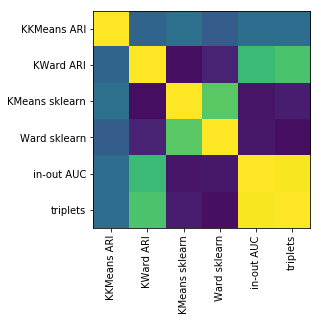

In [27]:
plt.imshow([[np.abs(a[i][j]) for j in range(6)] for i in range(6)], vmin=0, vmax=1)
plt.xticks(range(6), ['KKMeans ARI', 'KWard ARI', 'KMeans sklearn', 'Ward sklearn', 'in-out AUC', 'triplets'], rotation='vertical')
plt.yticks(range(6), ['KKMeans ARI', 'KWard ARI', 'KMeans sklearn', 'Ward sklearn', 'in-out AUC', 'triplets']);

## For KWard optimal params

Сначала насчитаем все кернелы по заранее определенным оптимальным параметрам

In [29]:
K = defaultdict(list)
D = defaultdict(list)
for kernel, distance in tqdm(zip(kernels, distances), total=len(kernels)):
    for A, _ in graphs:
        param_flat = optimal_params_KWard[kernel.name]
        param = kernel(A).scaler.scale(param_flat)
        K[kernel.name].append(kernel(A).get_K(param))
        D[kernel.name].append(distance(A).get_D(param))

Теперь насчитаем k-means ARI

In [30]:
KKMeans_ARI = defaultdict(list)
for kernel_name, K_k in tqdm(K.items()):
    for idx, K_k_g in enumerate(K_k):
        y_pred = KKMeans(2).fit_predict(K_k_g)
        ari = adjusted_rand_score(y_true[idx], y_pred)
        KKMeans_ARI[kernel_name].append(ari)

KKMeans_ARI_mean = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in KKMeans_ARI.items()])
sorted(KKMeans_ARI_mean.items(), key=lambda x: -x[1])

[('HeatPPR', 0.9647361633579142),
 ('logNHeat', 0.9631683459527706),
 ('SCCT', 0.9612246222105731),
 ('NHeat', 0.9612086857515736),
 ('logComm', 0.9600004421374787),
 ('Comm', 0.9226405513891097),
 ('logHeatPPR', 0.8972521120403283),
 ('Walk', 0.8469714786801297),
 ('logHeat', 0.6341073849337121),
 ('RSP', 0.44104656183467583),
 ('logPPR', 0.4275371419579802),
 ('FE', 0.4203252533904526),
 ('logFor', 0.4152119446382794),
 ('SCT', 0.39663151434680066),
 ('logModifPPR', 0.38134328044824023),
 ('PPR', 0.2853971808600781),
 ('pWalk', 0.21863887378829053),
 ('SP-CT', 0.09656005317797828),
 ('ModifPPR', 0.018062398810465913),
 ('Heat', 0.000766718987353317),
 ('For', 0.0)]

In [31]:
KWard_ARI = defaultdict(list)
for kernel_name, K_k in tqdm(K.items()):
    for idx, K_k_g in enumerate(K_k):
        y_pred = KWard(2).fit_predict(K_k_g)
        ari = adjusted_rand_score(y_true[idx], y_pred)
        KWard_ARI[kernel_name].append(ari)

KWard_ARI_mean = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in KWard_ARI.items()])
sorted(KWard_ARI_mean.items(), key=lambda x: -x[1])

[('logNHeat', 0.954251191032367),
 ('HeatPPR', 0.9507961888586284),
 ('logComm', 0.9501585573766177),
 ('NHeat', 0.9248817940948182),
 ('logHeat', 0.9122229842740258),
 ('Comm', 0.8774308428380035),
 ('SCT', 0.8410884670297055),
 ('PPR', 0.8382561907112048),
 ('logPPR', 0.8358272288647676),
 ('logModifPPR', 0.8358272288647676),
 ('RSP', 0.8343627009701194),
 ('logFor', 0.8327426565648517),
 ('FE', 0.8307556641629844),
 ('pWalk', 0.8232800694207366),
 ('Walk', 0.8153907842804982),
 ('SCCT', 0.7839314474827743),
 ('logHeatPPR', 0.7527653461981768),
 ('SP-CT', 0.6740885436286121),
 ('ModifPPR', 0.4102886020056552),
 ('Heat', 0.0025947270666485766),
 ('For', 0.0008186408963837058)]

In [32]:
KMeans_sklearn_ARI = defaultdict(list)
for kernel_name, K_k in tqdm(K.items()):
    for idx, K_k_g in enumerate(K_k):
        y_pred = KMeans_sklearn(2).fit_predict(K_k_g)
        ari = adjusted_rand_score(y_true[idx], y_pred)
        KMeans_sklearn_ARI[kernel_name].append(ari)

KMeans_sklearn_ARI_mean = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in KMeans_sklearn_ARI.items()])
sorted(KMeans_sklearn_ARI_mean.items(), key=lambda x: -x[1])

[('logPPR', 0.9682152281552803),
 ('RSP', 0.9678313744034359),
 ('SCT', 0.9674959847846182),
 ('FE', 0.9670717235612688),
 ('logModifPPR', 0.9663039617633621),
 ('logFor', 0.9662554657008643),
 ('logHeatPPR', 0.9655119590592772),
 ('SP-CT', 0.9647767176749096),
 ('HeatPPR', 0.9619924732012306),
 ('SCCT', 0.9612326730716518),
 ('PPR', 0.9592812537759321),
 ('logHeat', 0.9557133703441744),
 ('Walk', 0.9496845317693392),
 ('Heat', 0.7799190455172028),
 ('pWalk', 0.755455604219196),
 ('For', 0.6800849697617192),
 ('ModifPPR', 0.6321832668736022),
 ('Comm', 0.09645850647779328),
 ('logComm', 0.03217490986940263),
 ('NHeat', 0.005390259120421474),
 ('logNHeat', 0.0035551854318359227)]

In [33]:
Ward_sklearn_ARI = defaultdict(list)
for kernel_name, K_k in tqdm(K.items()):
    for idx, K_k_g in enumerate(K_k):
        y_pred = Ward_sklearn(2).fit_predict(K_k_g)
        ari = adjusted_rand_score(y_true[idx], y_pred)
        Ward_sklearn_ARI[kernel_name].append(ari)

Ward_sklearn_ARI_mean = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in Ward_sklearn_ARI.items()])
sorted(Ward_sklearn_ARI_mean.items(), key=lambda x: -x[1])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Ward_sklearn is deprecated; This is not a kernel method!
  warnings.warn(msg, cate

[('HeatPPR', 0.9515318748807858),
 ('SCCT', 0.9453497427724683),
 ('logHeat', 0.9387352430237683),
 ('logHeatPPR', 0.928241015405237),
 ('logPPR', 0.9103205309820788),
 ('logModifPPR', 0.9103205309820788),
 ('logFor', 0.907444467794717),
 ('FE', 0.9025841297468962),
 ('SCT', 0.9021185461367311),
 ('RSP', 0.8980835690576189),
 ('Walk', 0.8880648560628964),
 ('PPR', 0.8788676768032473),
 ('SP-CT', 0.855897572480282),
 ('Heat', 0.7535332940163607),
 ('pWalk', 0.7378851270339094),
 ('For', 0.5629618958353508),
 ('ModifPPR', 0.5556896407092445),
 ('Comm', 0.1795312917433716),
 ('logComm', 0.03105170028029119),
 ('NHeat', 0.015720566242688215),
 ('logNHeat', 0.003967595831501142)]

Хорошо, теперь давайте посмотрим на in-out

In [34]:
rq = defaultdict(list)
for kernel_name, D_m in tqdm(D.items()):
    for idx, D_m_g in enumerate(D_m):
        tpr, fpr = RejectCurve._reject_curve(D_m_g, y_true[idx], need_shuffle=True)
        rq[kernel_name].append(auc(tpr, fpr))

rq_avg = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in rq.items()])
sorted(rq_avg.items(), key=lambda x: -x[1])

[('logNHeat', 0.9849649110204082),
 ('HeatPPR', 0.982011198367347),
 ('logComm', 0.9753772685714286),
 ('Heat', 0.9260883167346937),
 ('NHeat', 0.9197041730612244),
 ('PPR', 0.8598310448979593),
 ('SCCT', 0.8535000244897959),
 ('Comm', 0.836284342857143),
 ('pWalk', 0.7999868310204081),
 ('logHeatPPR', 0.7991328816326532),
 ('SCT', 0.7515055983673469),
 ('Walk', 0.7159352244897959),
 ('RSP', 0.7125516930612246),
 ('FE', 0.6931895526530611),
 ('logFor', 0.6920280228571428),
 ('logPPR', 0.6905070122448982),
 ('logModifPPR', 0.6905070122448982),
 ('logHeat', 0.6629770448979592),
 ('SP-CT', 0.6017656114285713),
 ('For', 0.5416406318367347),
 ('ModifPPR', 0.5408422318367347)]

И теперь посмотрим на триплеты

In [35]:
triplet = defaultdict(list)
for kernel_name, D_k in tqdm(D.items()):
    for idx, D_k_g in enumerate(D_k):
        triplet[kernel_name].append(triplet_measure(y_true[idx], D_k_g))

triplet_avg = dict([(kernel_name, np.mean(scores)) for kernel_name, scores in triplet.items()])
sorted(triplet_avg.items(), key=lambda x: -x[1])

[('logNHeat', 0.9773321632653061),
 ('HeatPPR', 0.9739089795918366),
 ('logComm', 0.9709048979591836),
 ('Heat', 0.9398996734693877),
 ('NHeat', 0.9208194693877552),
 ('PPR', 0.8590898367346937),
 ('Comm', 0.8478581224489798),
 ('pWalk', 0.8177886122448979),
 ('logHeatPPR', 0.8035122857142858),
 ('SCT', 0.7849957142857142),
 ('Walk', 0.7490959591836734),
 ('RSP', 0.7470864897959183),
 ('SCCT', 0.7375360816326529),
 ('logHeat', 0.7351645714285715),
 ('FE', 0.7280849795918365),
 ('logFor', 0.7267908571428571),
 ('logPPR', 0.7251617959183673),
 ('logModifPPR', 0.7251617959183673),
 ('SP-CT', 0.6185283673469388),
 ('For', 0.5610517142857142),
 ('ModifPPR', 0.5600815510204081)]

In [36]:
good_results = optimal_params_KWard.keys()

In [37]:
chain_KKMeans_ARI = np.array(list(itertools.chain(*[KKMeans_ARI[x] for x in good_results])))
chain_KWard_ARI = np.array(list(itertools.chain(*[KWard_ARI[x] for x in good_results])))
chain_KMeans_sklearn_ARI = np.array(list(itertools.chain(*[KMeans_sklearn_ARI[x] for x in good_results])))
chain_Ward_sklearn_ARI = np.array(list(itertools.chain(*[Ward_sklearn_ARI[x] for x in good_results])))
chain_rq = np.array(list(itertools.chain(*[rq[x] for x in good_results])))
chain_triplet = np.array(list(itertools.chain(*[triplet[x] for x in good_results])))

chain_of_chains = [
    chain_KKMeans_ARI,
    chain_KWard_ARI,
    chain_KMeans_sklearn_ARI,
    chain_Ward_sklearn_ARI,
    chain_rq,
    chain_triplet
]

In [38]:
a = defaultdict(lambda: defaultdict(lambda: 0))
for i1, c1 in enumerate(chain_of_chains):
    for i2, c2 in enumerate(chain_of_chains):
        a[i1][i2] = ranking(c1, c2)

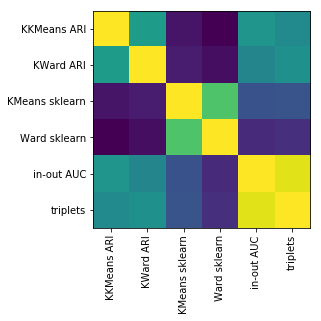

In [39]:
plt.imshow([[np.abs(a[i][j]) for j in range(6)] for i in range(6)], vmin=0, vmax=1)
plt.xticks(range(6), ['KKMeans ARI', 'KWard ARI', 'KMeans sklearn', 'Ward sklearn', 'in-out AUC', 'triplets'], rotation='vertical')
plt.yticks(range(6), ['KKMeans ARI', 'KWard ARI', 'KMeans sklearn', 'Ward sklearn', 'in-out AUC', 'triplets']);